# Image Classifier v2: train a model with your date

In the previous example, we show how to train an image classifier using an already prepared dataset ([The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/).

In this notebook, we will see how we can train a model using our data. If you already have a dataset with images based on a task that you want to build a classifier, you can go ahead and use those! 

If not, but you have an idea of what type of classification you want to do, here we will show how to create a fast dataset using DuckDuckGo search (i.e. create a dataset of mangos and avocados, of dogs breeds, etc). Feel free to experiment with whatever image task you prefer.

This example is based on Jeremy's Howard Kaggle notebook that you can find [here](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data). Kaggle notebooks are an excellent source of material and it is worth your time exploring them.

### Installation and imports

Let's start by installing the necessary libraries, and import the modules we will be using

In [1]:
!pip install -Uqq fastai fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 111.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# from duckduckgo_search import ddg_images
from fastai.vision.all import *
from fastcore.all import *
from fastbook import *

from fastdownload import download_url

In this example, we will build our own dataset by downloading images from the web. For doing so, we will need a function to help us download the images fast. We use therefore the function below:

Let's try out this function and see if the results that it returns make sense:

In [3]:
def search_images(term, max=30):
  print(f"Searching for '{term}'")
  return search_images_ddg(term, max_images=max)

In [4]:
urls = search_images('cat photos', max=2)
urls[1]

Searching for 'cat photos'


'http://www.wallpaperbetter.com/wallpaper/363/725/213/white-cat-cute-1080P-wallpaper.jpg'

So, from the urls we retrieved, we save the first one and we have a look:

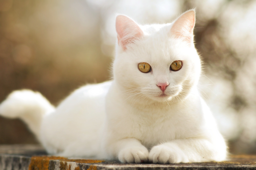

In [5]:
dest = 'cat.jpg'
download_url(urls[1], dest, show_progress=False)


im = Image.open(dest)
im.to_thumb(256,256)

Ok, so the result seems reasonable. Let's do the same test for the other category:

Searching for 'dog photos'


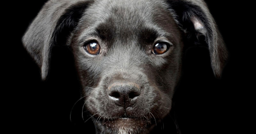

In [6]:
download_url(search_images('dog photos', max=1)[0], 'dog.jpg', show_progress=False)
Image.open('dog.jpg').to_thumb(256,256)

We are ready do create our dataset! The following code cell will create a folder for each category (cat and dog) and it will save the results of each search to the corresponding folder.

Note that the folders are not persistent. The contents are saved for as long as this Google Colab session keeps running. Once we close the current runtime, the contents will be deleted. So you don't have to worry about space issues.

If you wish to, you can navigate to the files contect of the session and download a copy of the folders created.

In [7]:
searches = 'cat','dog'
path = Path('cat_or_dog')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'cat photo'
Searching for 'dog photo'


When we download images in that way, sometimes there are image links that have failed. With the following cell we remove those cases.

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

Let's get the data ready for our model. A `DataBlock` gives fastai all the information it needs to build a model. So, basically we say get all the image files that we just downloaded. `ImageBlock` and `CategoryBlock` tells the model that what are input is image, and the output will be a category.

We then split the data into training and validation sets randomly, using 20% of the data for the validation set.

`get_y` is used to tell the model how to know which label corresponds to each image. It can be either a custom function. Here, we have them splitted into folders and `get_parent_label` returns the parent folder name.

`item_tfms` gives the instruction that before training, resize all images to 192x192 pixels by "squishing" them.

And finally, we say "show me a few" using `show_batch`. This helps us make sure that everything looks correct.

Here now, what it is going to do, is that it is going to take So, overall, it took less than 30' to complete the training.

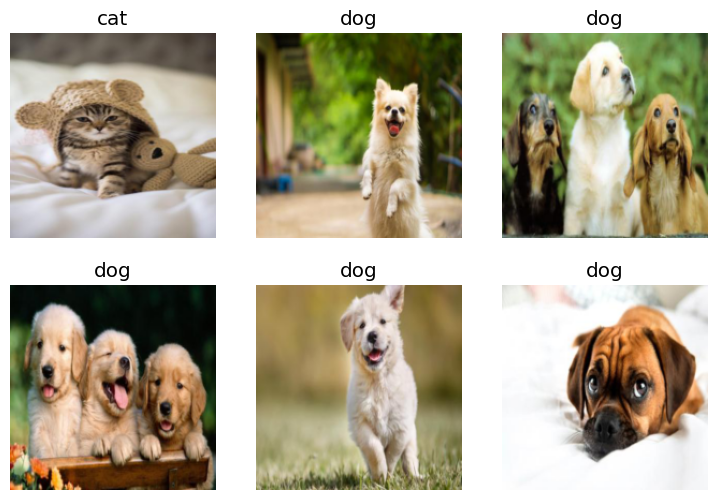

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Now we are ready to train our model! We will use the function called `vision_learner` in which we will pass `DataBlock` that we just created and the model name which we will fine-tune.

Fine-tuning in computer vision refers to the process of taking a pre-trained neural network model, which has already been trained on a large dataset, and further training it on a smaller, domain-specific dataset.

This allows us to save a lot of resources! Since we do not have to train a model from scratch! Here, fine-tune a resnet18 using 5 epochs.

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 346MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.041800,7.101109,0.545455,00:08


epoch,train_loss,valid_loss,error_rate,time
0,1.855733,5.160289,0.545455,00:01
1,1.484208,2.868480,0.545455,00:00
2,1.176975,0.918683,0.545455,00:00
3,0.881385,0.244891,0.090909,00:00
4,0.704561,0.109501,0.090909,00:00


And that's it! We see that the model after some epochs is performing greating! So let's try it out:

In [12]:
is_cat,_,probs = learn.predict(PILImage.create('cat.jpg'))
print(f"This is a: {is_cat}.")
print(f"Probability it's a cat: {probs[0]:.4f}")

This is a: cat.
Probability it's a cat: 1.0000


In [13]:
is_dog,_,probs = learn.predict(PILImage.create('dog.jpg'))
print(f"This is a: {is_dog}.")
print(f"Probability it's a dog: {probs[1]:.4f}")

This is a: dog.
Probability it's a dog: 0.9506


# Export the model

In [ ]:
learn.export('/content/drive/MyDrive/PyLadies/Meetup/dog_model_v2.pkl')